# Elegant Implementation on Subtask B: Explanation (Multi-Choice)
Updated on August 20, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask B is an Explanation (Multi-Choice) task. The purpose is to find the right reason why a given statement is against common sense.

*Example:*  
> **Task:** Select the most appropriate reason as to why this statement is against common sense.  
> **Statement:** He put an elephant into the fridge.  
> A: An elephant is much bigger than a fridge.  
> B: Elephants are usually white while fridges are usually white.  
> C: An elephant cannot eat a fridge.

#### Solution:
This program will follow the steps:
1. General Preparation   
2. Data processing
3. Loading the model and optimizer
4. Training
5. Testing

<!-- #### Task Description:
The subtask B is an Explanation (Multi-Choice) task. The purpose is to find the right reason why a given statement is against common sense.

*Example:* 

     Task: Select the most corresponding reason why this statement is against common sense.  
     Statement: He put an elephant into the fridge.  
     A: An elephant is much bigger than a fridge.  
     B: Elephants are usually white while fridges are usually white.  
     C: An elephant cannot eat a fridge. -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
cuda_id = 2
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:2 - TITAN RTX


## 2. Data processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [3]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'False Statement', 'Option A', 'Option B', 'Option C']).fillna(str())
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])
    return texts, labels

Read texts and labels from csv file.

In [4]:
train_texts, train_labels = get_info_from_csv(
    '../DataSet/Training Data/subtaskB_data_all.csv',
    '../DataSet/Training Data/subtaskB_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../DataSet/Dev Data/subtaskB_dev_data.csv',
    '../DataSet/Dev Data/subtaskB_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../DataSet/Test Data/subtaskB_test_data.csv',
    '../DataSet/Test Data/subtaskB_gold_answers.csv'
)

Let's have a look at the training data.

In [5]:
train_data = pd.merge(train_texts, train_labels, how='left', on='ID')
train_data.head()

,ID,False Statement,Option A,Option B,Option C,Answer
0,0,He poured orange juice on his cereal.,Orange juice is usually bright orange.,Orange juice doesn't taste good on cereal.,Orange juice is sticky if you spill it on the ...,B
1,1,He drinks apple.,Apple juice are very tasty and milk too,Apple can not be drunk,Apple cannot eat a human,B
2,2,"Jeff ran 100,000 miles today","100,000 miles is way to long for one person to...","Jeff is a four letter name and 100,000 has six...","100,000 miles is longer than 100,000 km.",A
3,3,I sting a mosquito,A human is a mammal,A human is omnivorous,A human has not stings,C
4,4,A giraffe is a person.,Giraffes can drink water from a lake.,A giraffe is not a human being.,.Giraffes usually eat leaves.,B


### 2.2 Tokenization

Define a common function to tokenize texts.

In [6]:
# Tokenization function for subtask B
def tokenize_for_task_B(texts, tokenizer, max_length=128):
    input_ids_list = list()
    attention_mask_list = list()
    
    for text in texts.values:
        encoding = tokenizer([[text[1], text[2]], [text[1], text[3]], [text[1], text[4]]], truncation="longest_first", padding="max_length", max_length=max_length)
        input_ids_list.append(encoding.input_ids)
        attention_mask_list.append(encoding.attention_mask)

    encodings = {"input_ids":input_ids_list,"attention_mask":attention_mask_list}
    return encodings

Tokenization for texts.

In [7]:
from transformers import DistilBertTokenizerFast

# Get tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization for texts
train_encodings = tokenize_for_task_B(train_texts, tokenizer)
val_encodings = tokenize_for_task_B(val_texts, tokenizer)
test_encodings = tokenize_for_task_B(test_texts, tokenizer)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [8]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Convert labels.

In [9]:
# Convert labels from the letters "A", "B", "C" to the numbers 0, 1, 2
def convert_labels(original_labels):
    labels = original_labels["Answer"]
    labels = [ord(label) - 65 for label in labels]
    return labels

train_labels = convert_labels(train_labels)
val_labels = convert_labels(val_labels)
test_labels = convert_labels(test_labels)

Turn encodings and labels into a Dataset object.

In [10]:
train_dataset = ComVEDataset(train_encodings, train_labels)
val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Loading the model and optimizer

In [11]:
from transformers import DistilBertForMultipleChoice, AdamW

model = DistilBertForMultipleChoice.from_pretrained('distilbert-base-uncased')
model.to(device)

optim = AdamW(model.parameters(), lr=5e-5)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForMultipleChoice: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForMultipleChoice from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForMultipleChoice from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForMultipleChoice were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']

## 4. Training

Prepare some utility functions.

In [12]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

Train the model.

In [13]:
# Training
from torch.utils.data import DataLoader

# Set the number of epochs
epochs = 3

# Get training data by DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Start training
model.train()

train_loss = list()
train_accuracies = list()
for epoch in range(epochs):
    print('Epoch %s/%s' % (epoch + 1, epochs))
    time.sleep(0.3)
    
    correct = 0
    count = 0
    epoch_loss = list()
    
    pbar = tqdm(train_loader)
    for batch in pbar:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optim.step()
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
        
        # record the loss for each batch
        epoch_loss.append(loss.item())
        
    pbar.close()
    
    # record the loss and accuracy for each epoch
    train_loss += epoch_loss
    train_accuracies.append(accuracy)

Epoch 1/3


100%|██████████| 625/625 [01:44<00:00,  5.96it/s, loss=0.602, accuracy=0.793]


Epoch 2/3


100%|██████████| 625/625 [01:55<00:00,  5.43it/s, loss=0.272, accuracy=0.910]


Epoch 3/3


100%|██████████| 625/625 [02:03<00:00,  5.08it/s, loss=0.452, accuracy=0.971]


Visualise the training loss and accuracy.

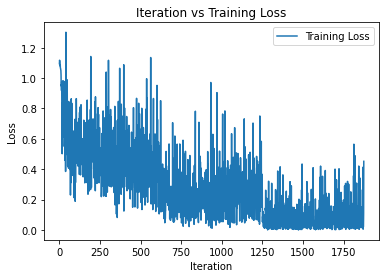

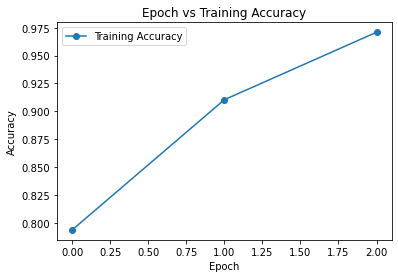

In [14]:
import matplotlib.pyplot as plt

# Plot Iteration vs Training Loss
plt.plot(train_loss, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Iteration vs Training Loss")  
plt.legend()
plt.show()

# Plot Epoch vs Training Accuracy
plt.plot(train_accuracies,"-o", label="Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Epoch vs Training Accuracy")  
plt.legend()
plt.show()

## 5. Testing

Test the model.

In [18]:
# Testing
from torch.utils.data import DataLoader

# Get test data by DataLoader
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Start testing
model.eval()

with torch.no_grad():
    
    correct = 0
    count = 0
    record = list()
    
    pbar = tqdm(test_loader)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs['loss']
        
        # make predictions
        predictions = predict(outputs)

        # count accuracy
        correct += predictions.eq(labels).sum().item()
        count += len(labels)
        accuracy = correct * 1.0 / count

        # show progress along with metrics
        pbar.set_postfix({
            'loss': '{:.3f}'.format(loss.item()),
            'accuracy': '{:.3f}'.format(accuracy)
        })
    
        # record the results
        record.append((int(labels),int(predictions)))
        
    pbar.close()
    
time.sleep(0.3)
print("The final accuracy on the test dataset: %s%%" % round(accuracy*100,4))

100%|██████████| 1000/1000 [00:07<00:00, 127.85it/s, loss=0.009, accuracy=0.791]


The final accuracy on the test dataset: 79.1%


Check the result.

In [16]:
# Convert test record to a pandas DataFrame object
from pandas.core.frame import DataFrame
df_record=DataFrame(record)
df_record.columns = ["Ground Truth","Model Prediction"]

# Convert labels from the numbers 0, 1, 2 to the letters "A", "B", "C"
df_record["Ground Truth"] = df_record["Ground Truth"].map(lambda x:chr(x+65))
df_record["Model Prediction"] = df_record["Model Prediction"].map(lambda x:chr(x+65))

# Concat test texts and test records
df = pd.concat([test_texts, df_record], axis=1)

# Show test result
pd.set_option('display.max_rows', None)
df

,ID,False Statement,Option A,Option B,Option C,Ground Truth,Model Prediction
0,1175,He loves to stroll at the park with his bed,A bed is too heavy to carry with when strollin...,walking at a park is good for health,Some beds are big while some are smaller,A,A
1,452,The inverter was able to power the continent.,An inverter is smaller than a car,An inverter is incapable of powering an entire...,An inverter is rechargeable.,B,B
2,275,The chef put extra lemons on the pizza.,Many types of lemons are to sour to eat.,Lemons and pizzas are both usually round.,Lemons are not a pizza topping.,C,C
3,869,sugar is used to make coffee sour,sugar is white while coffee is brown,sugar can dissolve in the coffee,sugar usually is used as a sweetener,C,C
4,50,There are beautiful planes here and there in t...,A plane flies upon the garden,You can have a small garden in your private plane,A plane can never be seen in garden,C,C
5,1155,"Once a pipe bursts, call a doctor.",Plumbers need to be trained.,plumbers fix the pipes while doctors cure sick...,Pipes come in all different sizes.,B,A
6,1395,Nobody hates paying taxes,Not everybody needs to pay the tax,Taxes eliminate a great amount of our income a...,"Nobody, taxes and everyone are English words",B,B
7,967,all whales are small,whales are actually mammals,whales come in different sizes but almost all ...,whale becomes whale fall after dead and feeds ...,B,B
8,906,the boat enjoyed rolling in the mud,mud is a mix of water and dirt,boats do not have emotions,boats can float on the water,B,B
9,1465,Barbies are the horrible desire for kids,the most horrible thing for the baby is that h...,some kids do not like barbies,There is nothing wrong with kids desiring doll...,C,C
